In [1]:
import numpy as np
import time as t
import matplotlib.pyplot as plt
import seaborn as sns

#  Sumowanie liczb pojedynczej precyzji

In [27]:
def absolute_error(exact_value, value):
    return abs(exact_value-value)

def relative_error(exact_value, value):
    return absolute_error(exact_value, value)/exact_value*100 if exact_value != 0 else 0

def sum_simple(arr, t):
    err = []
    axis = []
    s = np.float32(0.0)
    for i in range(len(arr)):
        s += arr[i]
        if t>=1 and i%t == 0:
            x = arr[0]*i
            err.append(relative_error(x, s))
            axis.append(i*arr[i])
    if t>=1:
        plt.plot(axis, err,  label='line 1', linewidth=2)
        plt.title('Relative error')
        plt.xlabel('Sum value')
        plt.show()
    return s


In [3]:
N = 10**7
v = np.float32(0.53125)
arr = [v]*N
exact_value = np.float32(5312500.0)

simple_sum = sum_simple(arr, 0)

print(f'Exact sum value: {exact_value}')
print(f'Simple sum value: {simple_sum}')
print(f'Absolute error: {absolute_error(exact_value, simple_sum)}')
print(f'Relative error: {relative_error(exact_value, simple_sum)}%')

Exact sum value: 5312500.0
Simple sum value: 5030840.5
Absolute error: 281659.5
Relative error: 5.301825702190399%


Błąd względny jest tak duży, gdyż dodajemy bardzo małą liczbę do coraz większej aktualnej sumy.

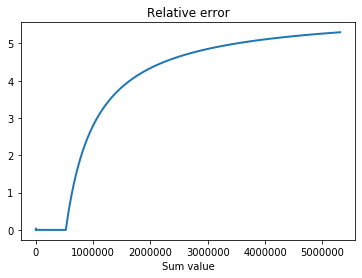

5030840.5

In [28]:
%matplotlib inline
sum_simple(arr, 2500)

Wykres przedstawia wartość błędu względnego w zależności od dotychczasowej wartości sumy. Można zauważyć, że błąd zaczyna mocno rosnąć, gdy suma osiąga wartość rzędu $10^5$, a dodajemy do niej ciągle liczbę rzędu $10^{-1}$. Jest to prawdopodobnie efekt tego, że po wyrównaniu cech do operacji dodawania bity mantysy liczby dodawanej są przesuwane w prawo i tracimy część z nich w wyniku zaokrąglenia lub obcięcia.

In [5]:
def sum_recu(arr):
    if len(arr) == 1:
        return arr[0]
    
    if len(arr)%2 == 1:
        arr.append(np.float32(0.0))
        
    arr = [arr[i]+arr[i+1] for i in range(0, len(arr), 2)]

    return sum_recu(arr)

In [6]:
recu_sum = sum_recu(arr)
print(f'Exact sum value: {exact_value}')
print(f'Simple sum value: {recu_sum}')
print(f'Absolute error: {absolute_error(exact_value, recu_sum)}')
print(f'Relative error: {relative_error(exact_value, recu_sum)}%')

Exact sum value: 5312500.0
Simple sum value: 5312500.0
Absolute error: 0.0
Relative error: 0.0%


Błąd względny zmalał, ponieważ w dodawaniu rekurencyjnym zawsze dodajemy do siebie takie same liczby, więc operacja ta nie wymaga wyrównywania cechy. Bity mantysy nie są więc tracone. 

Nie jest to generalna zasada. Wystarczy, aby w tablicy znalazły się obok siebie liczby znacznie różniące się od siebie, co demonstruje poniższy przykład.

In [7]:
arr2 = [np.float32(0.053125), np.float32(53125.0)]*10**3
recu_sum = sum_recu(arr2)
exact_value2 = np.float32(53125053.125)
print(f'Exact sum value: {exact_value2}')
print(f'Simple sum value: {recu_sum}')
print(f'Absolute error: {absolute_error(exact_value2, recu_sum)}')
print(f'Relative error: {relative_error(exact_value2, recu_sum)}%')

Exact sum value: 53125052.0
Simple sum value: 53125056.0
Absolute error: 4.0
Relative error: 7.529404655315375e-06%


# Algorytm Kahana

In [8]:
def sum_kahan(arr):
    s = np.float32(0.0)
    err = np.float32(0.0)
    for i in range(len(arr)):
        y = arr[i] - err
        temp = s + y
        err = (temp - s) - y
        s = temp

    return s

In [9]:
kahan_sum = sum_kahan(arr)
print(f'Exact sum value: {exact_value}')
print(f'Simple sum value: {kahan_sum}')
print(f'Absolute error: {absolute_error(exact_value, kahan_sum)}')
print(f'Relative error: {relative_error(exact_value, kahan_sum)}%')

Exact sum value: 5312500.0
Simple sum value: 5312500.0
Absolute error: 0.0
Relative error: 0.0%


Algorytm Kahana ma lepsze własności numeryczne, gdyż w każdej iteracji pętli w zmiennej $err$ zapamiętywane są bity, które utraciliśmy dodając mocno różniące się liczby. W kolejnej iteracji są one ponownie uwzględniane w operacji z kolejną "małą" liczbą (wartości tych dwóch składników sa podonego rzędu, więc odejmowanie/dodawanie jest dokładne). W ten sposób wartość przekazuje się dalej. 

Porównanie czasów działania 3 powyższych algorytmów:

| Algorytm               | Czas wykonania [s] |
|------------------------|--------------------|
| Proste sumowanie       |        1.21        |  
| Rekurencyjne sumowanie |        1.65        |  
| Algorytm Kahana        |        2.94        |  

# Sumy częściowe

In [12]:
def zeta_part(k, s, float_type):
    return np.power(float_type(k), float_type(-1.0) * s)

def eta_part(k, s, float_type):
    return zeta_part(k, s, float_type) if k % 2 == 1 else float_type(-1.0) * zeta_part(k, s, float_type)

def sum_forward(n, s, function, float_type):
    su = float_type(0.0)
    for i in range(n):
        su += function(i+1, s, float_type)
    return su
        
def sum_backward(n, s, function, float_type):
    su = float_type(0.0)
    for i in range(n,0,-1):
        su += function(i, s, float_type)
    return su

In [29]:
S = [2.0, 3.6667, 5.0, 7.2, 10.0]
N = [50, 100, 200, 500, 1000]

def generate_series(float_type):
    series = {
        'zeta_forward' : [],
        'zeta_backward' : [],
        'eta_forward' : [],
        'eta_backward' : []
        }

    for n in N:
        for key in series:
            series[key].append([])

        for s in S:
            series['zeta_forward'][-1].append(sum_forward(n, float_type(s), zeta_part, float_type))
            series['zeta_backward'][-1].append(sum_backward(n, float_type(s), zeta_part, float_type))
            series['eta_forward'][-1].append(sum_forward(n, float_type(s), eta_part, float_type))
            series['eta_backward'][-1].append(sum_backward(n, float_type(s), eta_part, float_type))
    
    return series

def compare(function):
    fig, (ax1, ax2) = plt.subplots(2,1, figsize=(20, 10))
    sns.heatmap(series_float32[function], annot=True, fmt=".8", cbar=False, ax=ax1, xticklabels=S, yticklabels=N)
    sns.heatmap(series_float64[function], annot=True, fmt=".16", cbar=False, ax=ax2,  xticklabels=S, yticklabels=N)
    ax1.set(title = 'Single precision', xlabel="S", ylabel = "N")
    ax2.set(title = 'Double precision', xlabel="S", ylabel = "N")
    plt.show()
    
series_float32 = generate_series(np.float32)
series_float64 = generate_series(np.float64)

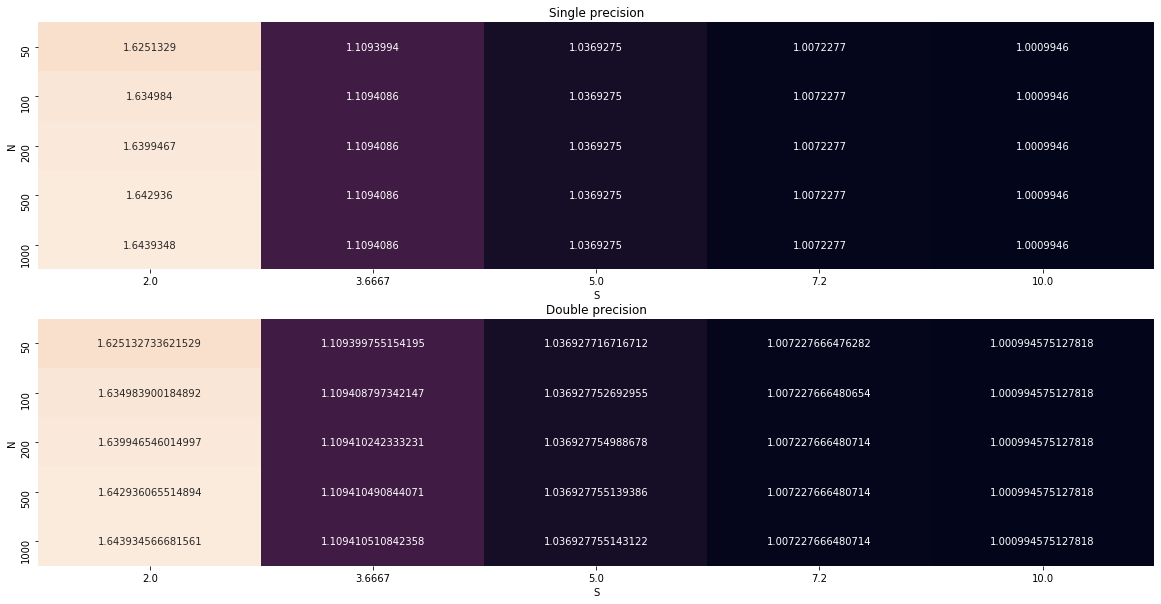

In [30]:
compare('zeta_forward')

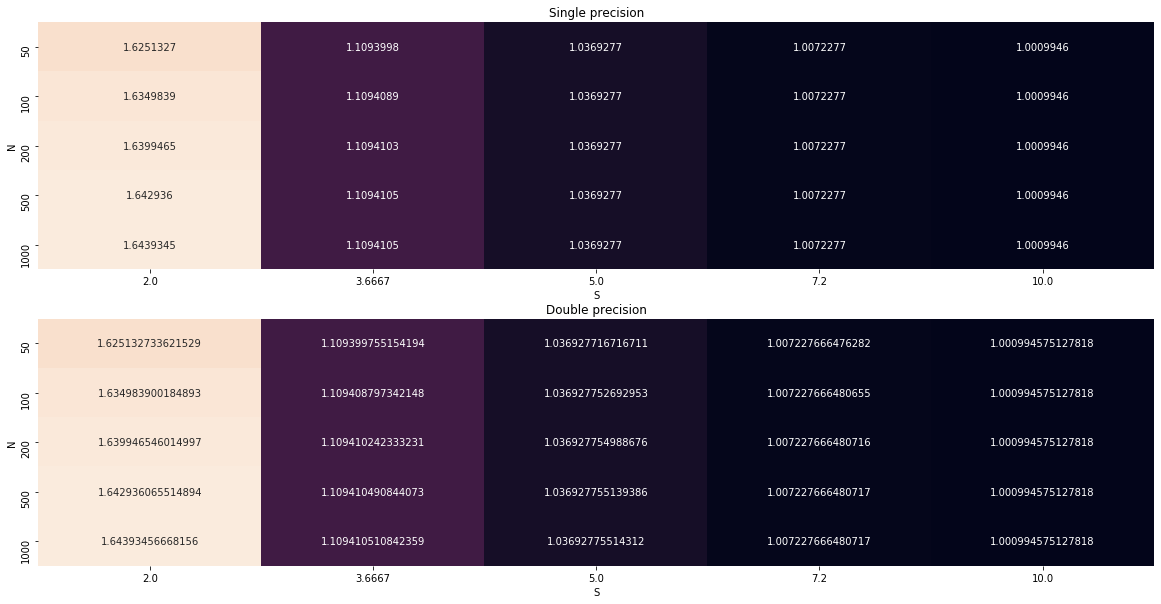

In [31]:
compare('zeta_backward')

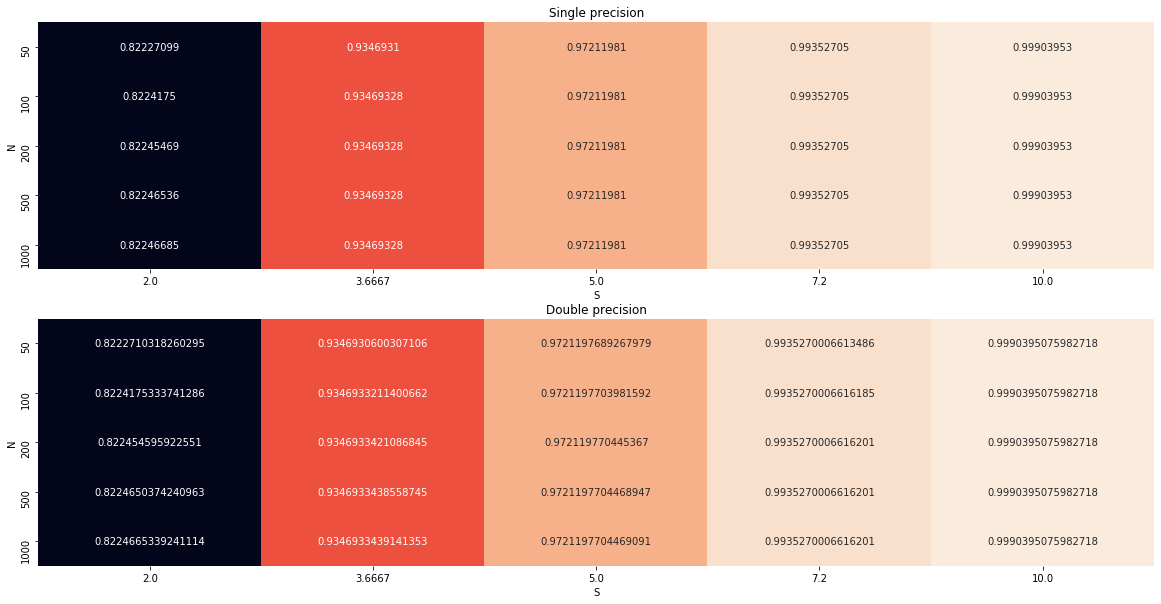

In [32]:
compare('eta_forward')

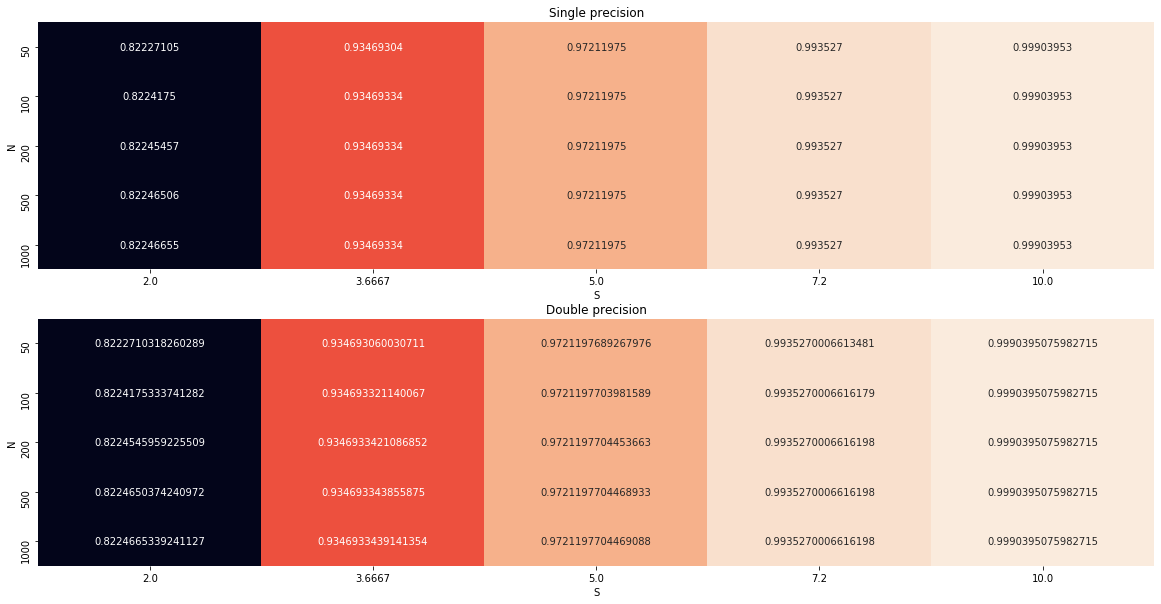

In [33]:
compare('eta_backward')

Możemy oszacować, że $$|{\frac{fl(fl(x+y)+)}{x+y+z}}| = |\varepsilon_1 + (\varepsilon_1 + \varepsilon_1 \varepsilon_2)\frac{x+y}{x+y+z}|\leq 2^{1-t}(1+\frac{|x+y|}{|x+y+z|})$$ 
(Ponieważ $fl(x+y)=(\varepsilon+1)(x+y)$ dla $\varepsilon \leq 2^{1-t}$, $\varepsilon_1 \varepsilon_2 << \varepsilon_1$, nierówność trójkąta)

Widzimy, że błąd względny otrzymanych wyników będzie różnie szacownay w zależności od kolejności wykonywania dodawania oraz precyzji, stąd możliwie różne wyniki sumowania. 


Przy obliczaniu sumy częściowej szeregu $\zeta(s)$ dla naturalnego $k$ zachodzi zależność $|\frac{1}{k^s} + \frac{1}{(k+1)^s}|<|\frac{1}{(k+1)^s} + \frac{1}{(k+2)^s}|$. Tak samo dla sumy częściowej $\eta(s)$ mamy $|(-1)^{k-1}\frac{1}{k^s} + (-1)^{k}\frac{1}{(k+1)^s}|<|(-1)^{k}\frac{1}{(k+1)^s} + (-1)^{k+1}\frac{1}{(k+2)^s}|$ 

Stąd, po zgeneralizowaniu oszacowań na większą liczbę wyrazów, dodawanie poszczególnych wyrazów sum częściowych od tyłu w obu przypadkach powinno być dokładniejsze. Co więcej, precyzja przechowywania powinna mieć mniejszy wpływ na wynik w przypadku sumowania wstecz, co można wywnioskować z oszcowania jak i zaobserwować w doświadczeniu (wyniki przy sumowaniu wstecz mniej się różnią między precyzjami).

# Błędy zaokrągleń i odwzorowanie logistyczne

In [35]:
def logistic(r, x, float_type):
    return float_type(r) * float_type(x) * (float_type(1.0) - float_type(x))

def bifurcation(r, X, n, on_diagram, float_type, marker=False, op=.25):
    fig, ax = plt.subplots(1, 3, sharey=True, figsize=(16, 5))
    for x_num, x in enumerate(X):
        
        x0 = x
        for i in range(n):
            x = logistic(r, x, float_type)
            if i >= (n - on_diagram):
                #print(type(x[0]))
                m = i%4+1 if marker else ','
                ax[x_num].plot(r, x, f'{m}k', alpha=op)
        ax[x_num].set(title=f'Bifurcation diagram for x_0 = {x0}', xlabel='r', ylabel='x_n')

Poniższe wykresy przedstawiają zachowanie ciągu rekurencyjnego $x_{n+1} = rx_n(1-x_n)$ po wielu iteracjach dla różnych wartości pierwszego wyrazu $x_0$. Na osi poziomej odłożono badane wartości parametru $r$.

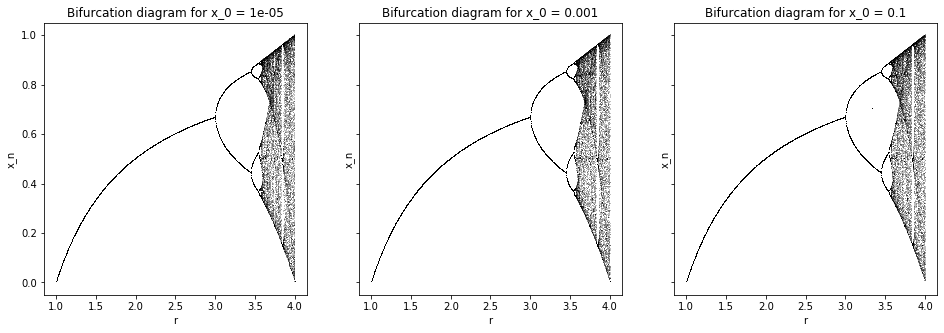

In [19]:
bifurcation(r=np.linspace(1.0, 4.0, 1000), X=[0.00001, 0.001, 0.1], n=1000, on_diagram=100, float_type=np.float32)  

Można zauważyć, że ciąg zachowuje się podobnie dla różnych wartości pierwszego wyrazu. Niezależnie od wartości początkowej, ciąg zbiega do konkretnej wartości dla $r \in [1, 3)$. Po prostych przekształceniach wzoru dostajemy, że jeśli ciąg jest zbieżny to może byc zbieżny tylko do granicy $\frac{r-1}{r}$ albo do $0$. Następnie dla $r \in (3, 3.45)$ oscyluje między dwoma wartościami, dla $r \in (3.45, 3.54)$ między czterema i kolejno dla coraz mniejszych przedziałów między kolejnymi $2^k$ punktami. Od $r\approx3.6$ ciąg zaczyna przybierać coraz bardziej chaotyczne wartości, czasami powracając do cyklicznego zachowania. W powyższym opisie przedziały zostały dobrane na podstawie obserwacji, nie matematycznego wyprowadzenia i nie są dokładne. 

Poniższe wykresy przedstawiają ten sam diagram bifurkacyjny dla ograniczonego $r \in [3.75, 3.8]$ dla liczb pojedyńczej i podwójnej precyzji. Dla lepszej widoczności ograniczono liczbę analizowanych promieni. W każdej kolumnie, kolejne wyrazy ciągu oznaczone są innymi symbolami.

Single precision


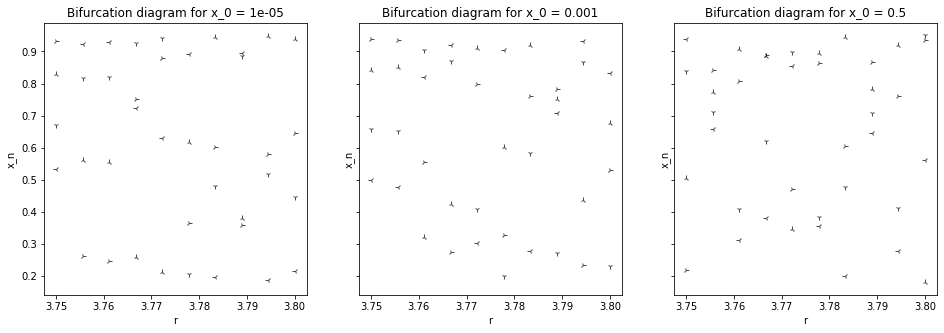

In [38]:
print('Single precision')
bifurcation(r=np.linspace(3.75, 3.8, 10), X=[0.00001, 0.001, 0.5], n=1000, on_diagram=4, 
            float_type=np.float32, marker=True, op=.7)  

Double precision


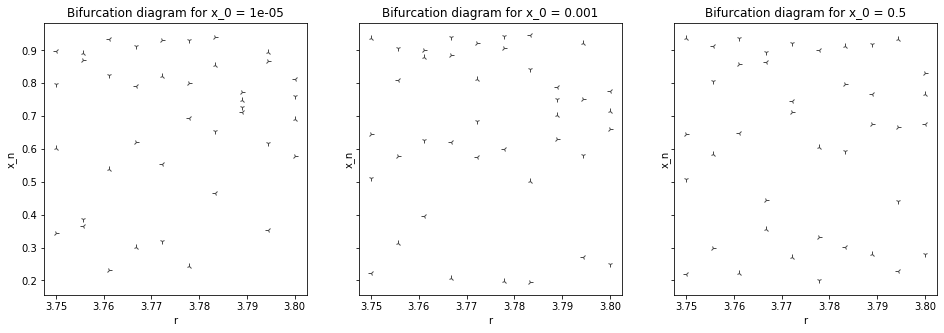

In [39]:
print('Double precision')
bifurcation(r=np.linspace(3.75, 3.8, 10), X=[0.00001, 0.001, 0.5], n=1000, on_diagram=4, 
            float_type=np.float64, marker=True, op=.7)   

Można poczynić dwie obserwacje:
* Chaosy generowane przez różne $x_0$ nie są tym samym chaosem.
* Precyzja zapamiętywania liczb wpływa na kolejne wyrazy ciągu. W wyniku mnożenia kolejne wyrazy ciągu mają coraz więcej cyfr znaczących, które w pewnym momencie muszą zostać zaokrąglone, ponieważ nie da się ich zapisać na bitach przeznaczonych na mantysę. Ten błąd zaokrąglenia przenosi się na kolejne wyrazy z powodu rekurencyjnej definicji ciągu. Stąd w zależności od długości mantysy możemy otrzymać wyniki różniące się na tyle, że nie jest nawet zachowana monotoniczność kolejnych wyrazów analizowanego ciagu. 

Poniżej przedstawiona jest analiza przypadku $r = 4$

In [25]:
def count_iterations(x):
    n = 0
    while np.float32(0.0) != x:
        x = logistic(4.0, x, np.float32)
        n += 1
        if n == 10**6:
            return 'probably infinity'
        
    return n

In [26]:
print(f'Iterations for x_0 = 0.00001: {count_iterations(np.float32(0.00001))}')
print(f'Iterations for x_0 = 0.001: {count_iterations(np.float32(0.001))}')
print(f'Iterations for x_0 = 0.1: {count_iterations(np.float32(0.1))}')
print(f'Iterations for x_0 = 0.5: {count_iterations(np.float32(0.5))}')

Iterations for x_0 = 0.00001: 40
Iterations for x_0 = 0.001: 705
Iterations for x_0 = 0.1: probably infinity
Iterations for x_0 = 0.5: 2


Dla ciągu $x_{n+1} = 4x_n(1-x_n)$ zachodzi następująca zależność $x_n = sin^2(2\pi y_n)$, gdzie ${\displaystyle y_{n+1}={\begin{cases}2y_{n}&0\leq y_{n}<{\tfrac {1}{2}}\\2y_{n}-1&{\tfrac {1}{2}}\leq y_{n}<1\end{cases}}}$. Kolejne wyrazy ciagu $y_n$ są uzyskiwane poprzez pomnożenie wcześniejszego wyrazu prze $2$ i ewentualne obcięcie jedynki z przodu, jeżeli taka się pojawi, dlatego dla każdej liczby maszynowej w pewnym momencie ciąg $y_n$ powinien osiągnąć $0$. Można zatem wywnioskować, że dla każdej maszynowej wartości początkowej, również ciąg $x_n$ powinien przyjąć wartość 0. Jednak jest to tylko teoretyczna zależność i zakłada liczenie kolejnych wyrazów bez zaokrągleń, z nieskończoną precyzją jakią nie dysponuje komputer.. Stąd np. dla $x_0 = 0.1$ ciąg prawdopodobnie nie osiągnie wartośći $0$.

[Źródło przedstawionej zależności.](https://en.wikipedia.org/wiki/Logistic_map#Solution_when_r_=_4)